# Semantic Segmentation of Smoke in GOES Satellite Imagery

## Dataset Learning Notebook
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/blob/main/Machine_Learning.ipynb)

**Learning Notebook 2 of 2**


---

**Author:** Rey Koki (CIRES / NOAA GSL)  
**Contact:** rey.koki@noaa.gov  
**Acknowledgments:** This work was supported by the NOAA National Centers for Environmental Information (NCEI).

### Overview
This notebook guides users through building and training a deep learning model for pixel-wise smoke detection in GOES satellite imagery. It uses a dataset created from NOAA's GOES-16 ABI L1b imagery and HMS smoke annotations. The notebook covers data preprocessing, implementation of a PSPNet-based segmentation model, training procedures, and performance evaluation. It is designed to demonstrate how NOAA-hosted datasets can be used for real-world environmental monitoring with machine learning.

### Prerequisites


To successfully complete this notebook, users should have:

* **Basic Python skills**, including experience with Jupyter notebooks  

* **Familiarity with satellite imagery** and basic remote sensing concepts  
  * [GOES-R Series Overview](https://www.goes-r.gov/)
    

* **Introductory understanding of deep learning**, especially image segmentation  
    * [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

* **Working knowledge of PyTorch**
    * [Pytorch Segmentation Models](https://smp.readthedocs.io/en/latest/)

* **GPU access** is recommended for training (e.g., Google Colab, local CUDA-enabled machine, or HPC system)

**Optional:**
* Awareness of [PSPNet](https://arxiv.org/abs/1612.01105), the model architecture used in this notebook  
* Familiarity with evaluation metrics like Intersection over Union (IoU)

### Learning Objectives

#### Data Exploration Objectives
1. Understand the structure and organization of the dataset directory  
2. Learn how to read and handle `.tif` files used for imagery and labels  
3. Visualize raw input imagery  
4. Visualize label masks  
5. Overlay labels on imagery for visual inspection  
6. Explore the dataset by iterating through samples  

#### Deep Learning Objectives
1. Understand the required software dependencies  
2. Recognize hardware requirements for training and inference  
3. Review the data preparation workflow for machine learning  
4. Examine the architecture of the segmentation model  
5. Understand the performance metric used for evaluation  
6. Load and run inference with a pre-trained model  
7. Design and train a custom segmentation model  
8. Continue training from a pre-trained model  


### Time Estimate
* Estimated text reading time: 15 to 25 min
* Estimated code reading time: 10 to 20 min
* Estimated total reading time: 25 to 45 min


In [3]:
import os

# Check if running inside Google Colab by comparing current working directory
if os.getcwd() == '/content':
    print("You are working in a Google Colab notebook!\nLet's grab the data and code from GitHub.\n")    
    # Remove any existing directories to avoid conflicts
    !rm -r Get_GOES scripts figures data   
    # Clone the Smoke Semantic Segmentation Learning Notebook repository
    !git clone git@github.com:reykoki/Smoke_Semantic_Segmenation_Learning_Notebook.git    
    # Remove the Deep Learning notebook from the cloned repo to avoid duplicates
    !rm Smoke_Semantic_Segmenation_Learning_Notebook/SmokeViz_Chapter_2_Deep_Learning.ipynb    
    # Move all files from the cloned repo into the current working directory
    !mv Smoke_Semantic_Segmenation_Learning_Notebook/* .    
    # Install required dependencies listed in requirements.txt
    !pip install -r requirements.txt

In [21]:
# Import Python libraries
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
import os
import time
from datetime import datetime
import wget
from IPython.display import Image, display
import sys
import segmentation_models_pytorch as smp
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
from torchvision import transforms
import torch.nn as nn
sys.path.insert(1, './scripts')
from torchinfo import summary
from IPython.display import clear_output

## 1. Data Exploration

Exploring the dataset is a key step to verify data integrity and gain familiarity with its structure and contents.

### Data Exploration Objectives
1. Understand the data directory structure
2. Learn how to handle `.tif` files
3. Visualize input imagery
4. Visualize label masks
5. Overlay labels on imagery for inspection
6. Browse the dataset by iterating through samples


### 1.1. Data Storage

```
sample_data
└───data
│   └───2022
│       └───Heavy 
│           │   G17_s20221351350321_e20221351359388_63.tif
│           │   ...
│       └───Medium 
│           │   ...
│       └───Light 
│           │   ...
│   └───...
└───truth
│   └───2022
│       └───Heavy 
│           │   G17_s20221351350321_e20221351359388_63.tif
│           │   ...
│       └───Medium 
│           │   ...
│       └───Light 
│           │   ...
│   └───...
└───coords
│   └───2022
│       └───Heavy 
│           │   G17_s20221351350321_e20221351359388_63.tif
│           │   ...
│       └───Medium 
│           │   ...
│       └───Light 
│           │   ...
│   └───...
```
### 1.2 Data Format

The input imagery, labels, and coordinates are stored as `.tif` files. This format is widely used for satellite data and offers several advantages:
- Avoids the overhead of compression and decompression associated with formats like `.png`
- Suitable for applications where compression is unnecessary
- Allows for straightforward stacking of multiple data layers

We use the [`scikit-image`](https://scikit-image.org/) library (`skimage`) to read and process these files.

### 1.3 Plotting the Data

#### 1.3.1 Simple Plot

Given a `.tif` filename, display the GOES True Color image.

G16_s20232680016174_e20232680018547_22.tif


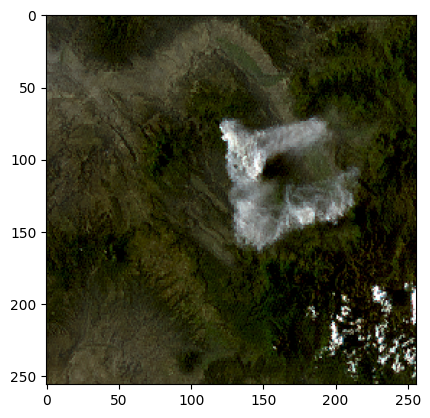

In [4]:
# Define the filename for a GOES-16 True Color composite image (tif format)
fn = 'G16_s20232680016174_e20232680018547_22.tif'
print(fn)

# A simple plotting function for visualizing the GOES sample data
def plot_simple(fn, data_loc="./sample_data/"):
    # Load the sample from the tif file
    RGB = skimage.io.imread(glob(data_loc + "data/*/*/" + fn)[0], plugin='tifffile')
    plt.imshow(RGB)
    plt.show()

# Display data sample GOES image
plot_simple(fn)


#### 1.3.2 Advanced Plotting

For more detailed visualizations, use the plotting functions in `./scripts/plot_tifs.py`. These functions provide additional context such as latitude, longitude, and timestamp information.

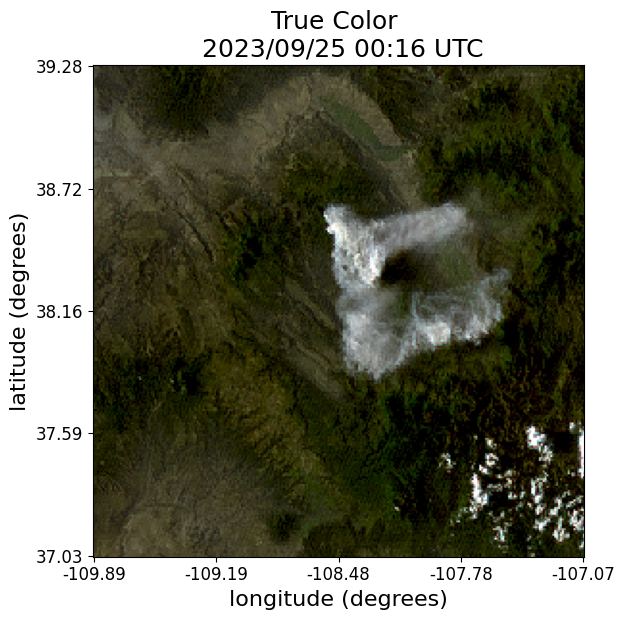

In [5]:
# Import more advanced plotting functions from the local module ./scripts/plot_tifs.py
from plot_tifs import plot_True_Color, plot_densities_from_processed_data, plot_R_G_B, plot_labels

# Plot the True Color composite image using the filename defined above (fn)
plot_True_Color(fn)

#### 1.3.3. Plot out each channel
**note** that this data has been pre-processed with corrections and a simulated green channel. See [SmokeViz_Chapter_1_Dataset.ipynb](https://github.com/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/blob/main/SmokeViz_Chapter_1_Dataset.ipynb) for more information.

G16_s20232680016174_e20232680018547_22.tif
center lat, lon: (38.31, -108.66)


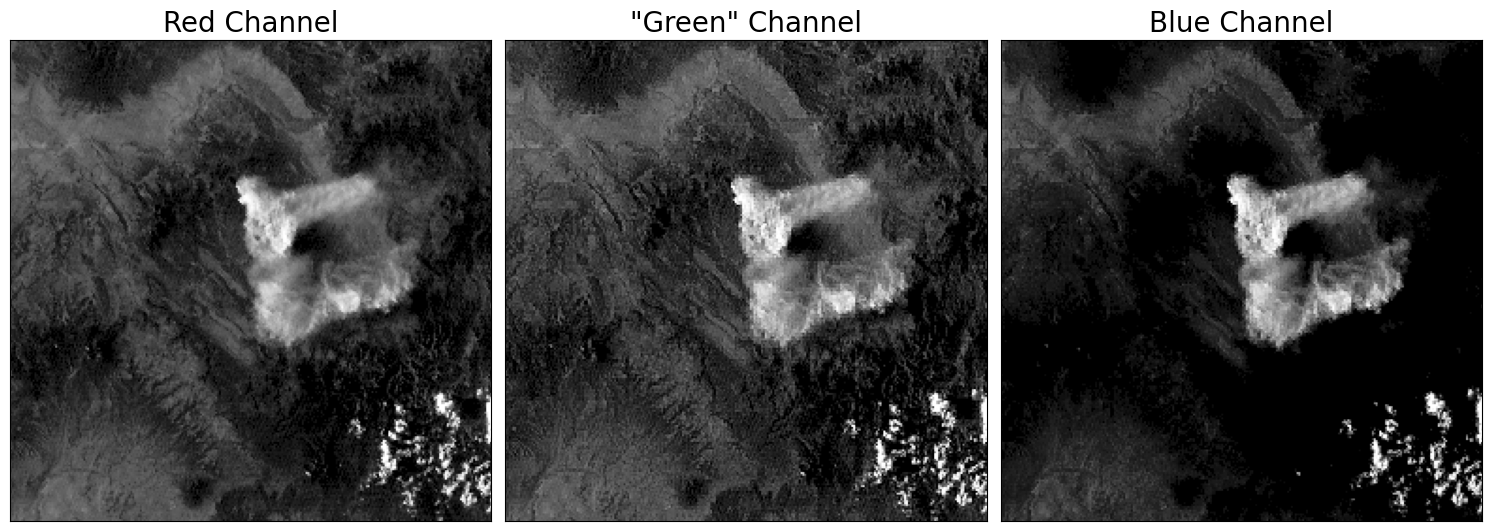

In [6]:
# plot_R_G_B: Plots the individual Red, Green, and Blue channels for analysis
plot_R_G_B(fn)

### 1.4. Plot Labels

Smoke density is categorized into three levels: **light**, **medium**, and **heavy**. These categories are encoded using binary vectors consisting of 0s and 1s.

To preserve the [ordinal](https://en.wikipedia.org/wiki/Ordinal_data) nature of smoke intensity, we use [thermometer encoding](https://research.google/pubs/thermometer-encoding-one-hot-way-to-resist-adversarial-examples/), which allows the model to recognize the ordered relationship between classes.

| Density | Thermometer Encoding | 
| :-: | :-: |
| Light | `[0, 0, 1]` | 
| Medium | `[0, 1, 1]` | 
| Heavy | `[1, 1, 1]` | 

<a id='thermometer_encoding'></a>

G16_s20232680016174_e20232680018547_22.tif


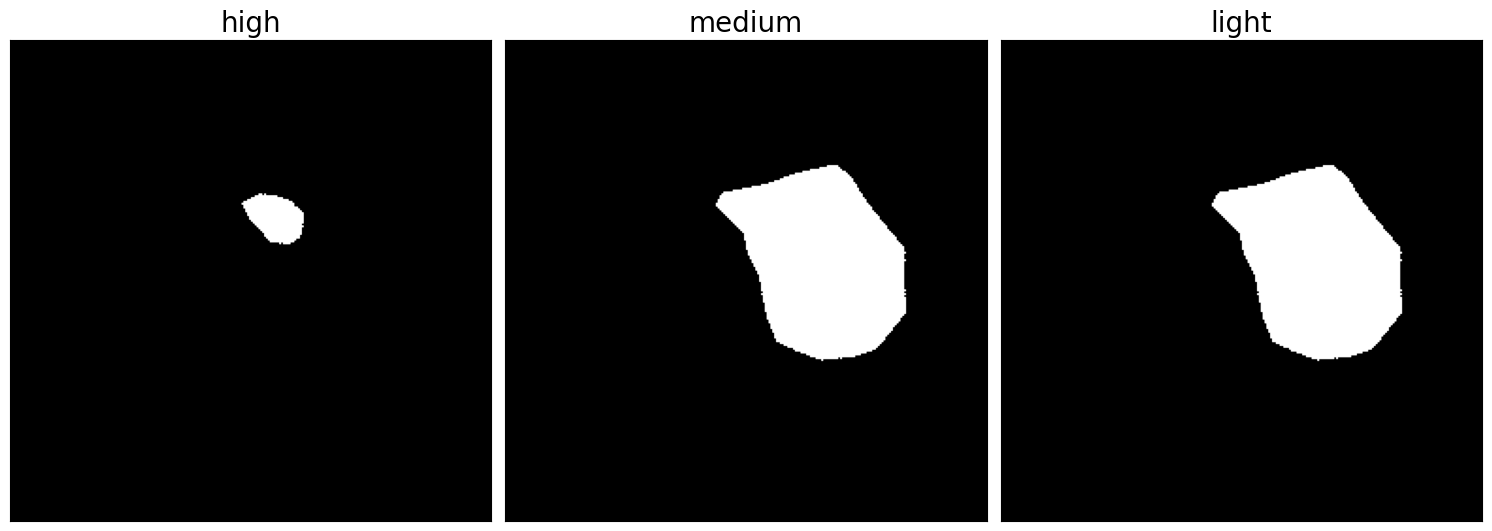

In [7]:
# plot_labels: Displays the label mask (e.g., smoke vs. no smoke)
plot_labels(fn)

### 1.5. Plot data with labels

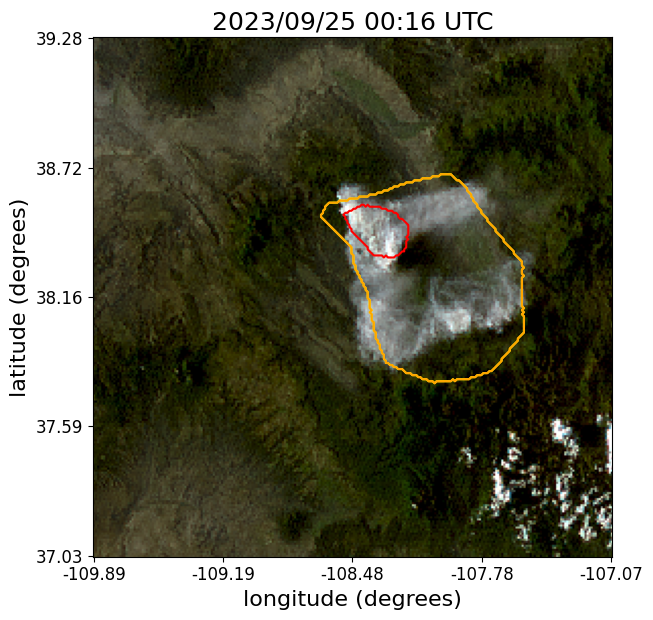

In [8]:
# plot_densities_from_processed_data: Visualizes smoke density classes (e.g., light/medium/heavy)
plot_densities_from_processed_data(fn)

### 1.6 Iterate Through Imagery

Loop through a subset of the dataset to explore the imagery and gain a better understanding of the smoke patterns and labeling used for model training.

G16_s20180681532218_e20180681534591_65.tif


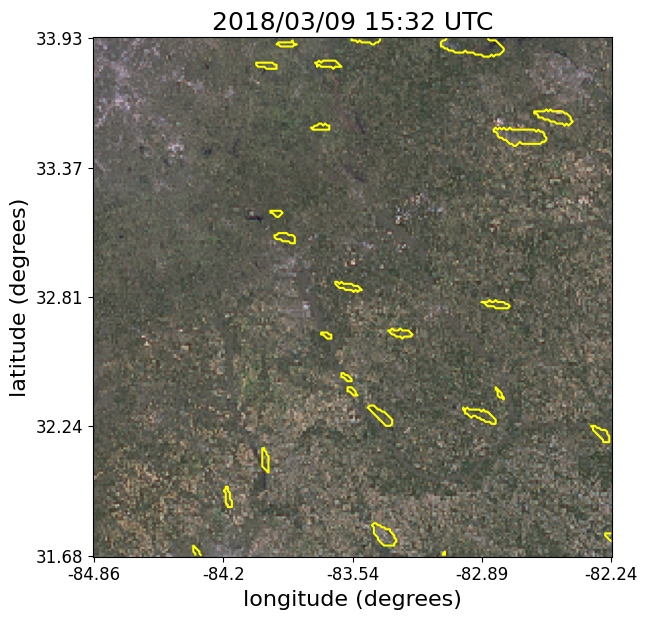

press enter for next, type anything to end: x


In [9]:
# Cycle through all imagery files in the dataset and visualize smoke density masks
def cycle_through_imagery(data_loc="./sample_data/"):
    # Get a list of all data filenames
    fns = [os.path.basename(x) for x in glob(data_loc + "data/*/*/*")]
    
    # Loop through each image filename
    for fn in fns:
        print(fn)  # Print the current file being displayed
        
        # Plot the smoke density mask or processed image for the current file
        # close=True will close the figure after displaying
        plot_densities_from_processed_data(fn, close=True)
        
        # Wait for user input to proceed or stop
        x = input('Press Enter to show the next image, or type anything to exit: ')
        if x != '':
            break  # Exit the loop if the user types anything
        
        # Clear the notebook cell output for a clean display in each iteration
        clear_output()

# Run the interactive cycle through imagery
cycle_through_imagery()


# 2. Deep Learning
---

### Deep Learning Objectives
1. Software
2. Hardware
3. Machine learning data workflow
4. Model architecture
5. Performance metric
6. Load and run a pre-trained model
7. Create your own model
8. Continue training from a pre-trained model

### 2.1 Software: PyTorch and Jupyter

[PyTorch](https://pytorch.org/) is a widely used deep learning library that supports dynamic computation graphs and flexible model development. It is especially well suited for research and rapid prototyping.

[Jupyter Notebooks](https://jupyter.org/) provide an interactive, document-based environment ideal for combining code, visualization, and narrative text. This format makes it easier to experiment with models and share results.

### 2.2 Hardware: GPUs for Deep Learning

Before training, check whether your environment has access to a GPU. Graphics Processing Units (GPUs) are optimized for performing many simple computations in parallel, making them well suited for deep learning workloads. While GPUs were originally designed for rendering graphics, their architecture also accelerates matrix operations used in neural networks.

In PyTorch, defining a `device` object allows your code to adapt automatically to the available hardware. If a GPU is available, it will be used; otherwise, the code will fall back to the CPU without requiring any changes.

In [12]:
# Check if a CUDA-capable GPU is available; if so, use it; otherwise, fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used for model training or inference
print('You are running on a', device)

You are running on a cpu


### 2.3. Deep Learning Data Workflow

#### 2.3.1. Machine Learning Dataset Basics


The dataset is organized into training, validation, and testing splits, with file paths stored in a pickled dictionary named `data_dict.pkl`.

`data_dict` structure:

```
data_dict = {'train': {'data':  ['./sample_data/data/YYYY/{DENSITY}/SAT_sYYYYdddHHMMSSss_eYYYYdddHHMMSSss_idx.tif'],
                       'truth': ['./sample_data/truth/YYYY/{DENSITY}/SAT_sYYYYdddHHMMSSss_eYYYYdddHHMMSSss_idx.tif']},
             'val':   {'data':  ['./sample_data/data/YYYY/{DENSITY}/SAT_sYYYYdddHHMMSSss_eYYYYdddHHMMSSss_idx.tif'],
                       'truth': ['./sample_data/truth/YYYY/{DENSITY}/SAT_sYYYYdddHHMMSSss_eYYYYdddHHMMSSss_idx.tif']},                     
             'test':  {'data':  ['./sample_data/data/YYYY/{DENSITY}/SAT_sYYYYdddHHMMSSss_eYYYYdddHHMMSSss_idx.tif'],
                       'truth': ['./sample_data/truth/YYYY/{DENSITY}/SAT_sYYYYdddHHMMSSss_eYYYYdddHHMMSSss_idx.tif']}}

```
The training set includes data from 2018 to 2023, excluding 2022 and 2024. The year 2022 is used exclusively for validation, while 2024 is reserved for testing. 


dataset | year 
---|---
**training** | 2018, 2019, 2020, 2021, 2023 
**validation** | 2022 
**testing** | 2024 


In [13]:
# Load the dataset metadata dictionary from a pickle file
# 'data_dict.pkl' defines the data splits and their data and truth filepaths
with open('data_dict.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)

#### 2.3.2. PyTorch Dataset 
A custom PyTorch `Dataset` loads input images and their corresponding labels from `.tif` files. It supports efficient batching and iteration using a `DataLoader`.


In [14]:
# Define a custom PyTorch Dataset for loading GOES imagery and smoke labels
class SmokeDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        # data_dict is a dictionary with keys 'data' (input images) and 'truth' (labels)
        self.data_fns = data_dict
        self.transform = transform  # Transformations applied to both data and labels

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data_fns['data'])

    def __getitem__(self, idx):
        # Get file paths for the data and the corresponding label
        data_fn = self.data_fns['data'][idx]
        truth_fn = self.data_fns['truth'][idx]

        # Read the input GOES data image and the label smoke mask
        data_img = skimage.io.imread(data_fn, plugin='tifffile')
        truth_img = skimage.io.imread(truth_fn, plugin='tifffile')

        # Apply the transformation (e.g., ToTensor) to both images
        data_tensor = self.transform(data_img)
        truth_tensor = self.transform(truth_img)

        # Convert the label tensor to float (useful for BCE loss or continuous masks)
        truth_tensor = truth_tensor.type(torch.float)

        # Return data tensor, label tensor, and the base filename for reference
        return data_tensor, truth_tensor, os.path.split(data_fn)[1]

# Define transformations: convert images to PyTorch tensors
data_transforms = transforms.Compose([transforms.ToTensor()])

# Create a test dataset using the custom SmokeDataset class
# data_dict['test'] contains the test data and label paths
test_set = SmokeDataset(data_dict['test'], data_transforms)

#### Test set

The test set is fully held out during training and is only used for final evaluation. While the validation set is used to monitor performance between epochs, the test set provides an unbiased assessment after training is complete.

To evaluate the model, we both visualize and quantify its performance on the test set to check for overfitting and generalization.

#### 2.3.3. PyTorch DataLoader

The `DataLoader` provides an efficient way to iterate over the `Dataset` by handling batching, shuffling, and parallel loading during training and evaluation.


In [15]:
# Create a DataLoader for the test dataset
# batch_size=1: Each batch will contain a single image and label pair
# shuffle=False: Keep the test data order fixed (important for evaluation)
# drop_last=True: Drop the last batch if it is incomplete (not divisible by batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, drop_last=True)
print('There are {} items in the test dataset'.format(len(test_loader)))

There are 10 items in the test dataset


#### 2.3.3.1. Visualization of DataLoader Contents

We can inspect a sample directly from the PyTorch `DataLoader`.

The shape of both the input and label tensors is `[1, 3, 256, 256]`, corresponding to `[batch_size, channels, height, width]`.

filename: G17_s20221351350321_e20221351359388_63.tif 
dimensions of data: torch.Size([1, 3, 256, 256]) 
dimensions of label: torch.Size([1, 3, 256, 256])


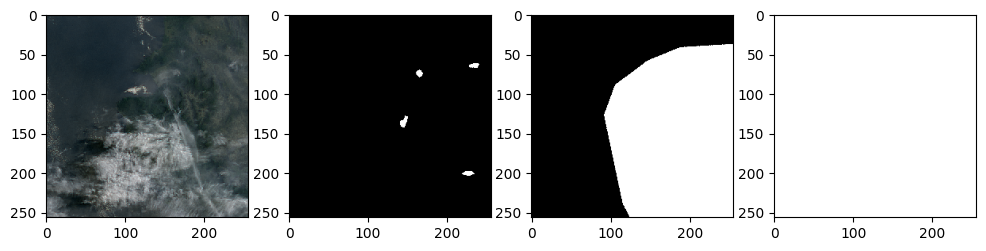

In [16]:
# Iterate through the test_loader (batch_size=1, so each iteration gives a single sample)
for item in test_loader:
    # Unpack the data tensor, ground truth tensor, and filename from test_loader iterator
    data_tensor, truth_tensor, fn = item
    
    print("filename: {} \ndimensions of data: {} \ndimensions of label: {}".format(
        fn[0], data_tensor.shape, truth_tensor.shape))
    fig, ax = plt.subplots(1, 4, figsize=(12, 30))
    
    # Display the RGB image
    # Reorder the data PyTorch tensor from (channels, width, height) to (width, height, channels)
    ax[0].imshow(torch.einsum('cwh->whc', data_tensor.squeeze()))
    
    # Prepare the truth PyTorch tensor for visualization (reorder to (width, height, channels))
    truth_tensor = torch.einsum('cwh->whc', truth_tensor.squeeze())
    
    # Display the 3 smoke density classes (Light, Medium, Heavy) binary smoke masks
    for idx in range(1, 4):
        ax[idx].imshow(truth_tensor[:, :, idx-1], cmap='Greys_r', vmin=0, vmax=1)
    # plot directly from filename instead of from PyTorch DataLoader
    # plot_densities_from_processed_data(fn[0]) 
    break


### 2.4. Define model

We use [PSPNet](https://arxiv.org/abs/1612.01105), a Pyramid Scene Parsing Network designed to handle objects at multiple spatial scales. PSPNet improves segmentation performance by capturing both local and global context.

Key features that support multi-scale segmentation:
- **Pyramid pooling** to aggregate context at multiple resolutions  
- **Dilated convolutions** to increase receptive field without reducing resolution  
- **Image pyramiding** to improve scale-awareness


<img src=https://production-media.paperswithcode.com/methods/new_pspnet-eps-converted-to.jpg width="700">

We implement PSPNet using the [pytorch segmentation_models](https://smp.readthedocs.io/en/latest/) library, which provides a high-level interface for common segmentation architectures.

In [41]:
# Define a segmentation model using the segmentation_models_pytorch (smp) library
def define_model(segmentation_model, encoder, device, print_summary=False):
    model = smp.create_model(
            arch=segmentation_model,
            encoder_name=encoder,  
            encoder_weights=None,                 # No pre-trained weights are used (can set to 'imagenet' for transfer learning)
            in_channels=3,                        # Number of input channels (e.g., RGB image)
            classes=3,                            # Number of output classes (e.g., Light, Medium, Heavy smoke)
    )
    if print_summary:
        # Print a summary of the model architecture, showing layers and parameter counts.
        # The input size is specified as (channels, height, width).
        print(summary(model, input_size=(1, 3, 256, 256)))
    model = model.to(device)
    return model
    
# PSPNet (Pyramid Scene Parsing Network) is designed for pixel-wise segmentation tasks.
segmentation_model = "PSPNet"
# Use EfficientNet-B0 as the encoder backbone (lightweight and efficient)
encoder = "timm-efficientnet-b0"
model = define_model(segmentation_model, encoder, device, print_summary=True)

Layer (type:depth-idx)                                  Output Shape              Param #
PSPNet                                                  [1, 3, 256, 256]          --
├─EfficientNetEncoder: 1-1                              [1, 3, 256, 256]          412,160
│    └─Conv2d: 2-1                                      [1, 32, 128, 128]         864
│    └─BatchNormAct2d: 2-2                              [1, 32, 128, 128]         64
│    │    └─Identity: 3-1                               [1, 32, 128, 128]         --
│    │    └─Swish: 3-2                                  [1, 32, 128, 128]         --
│    └─Sequential: 2-3                                  --                        3,529,658
│    │    └─Sequential: 3-3                             [1, 16, 128, 128]         1,448
│    │    └─Sequential: 3-4                             [1, 24, 64, 64]           16,714
│    │    └─Sequential: 3-5                             [1, 40, 32, 32]           46,640
├─PSPDecoder: 1-2                   

### 2.4.1 Load a Trained Model

We experiment with a semantic segmentation model that has already been trained to detect smoke in GOES imagery.

#### 2.4.1.1 PyTorch Checkpoint

We use a [general PyTorch checkpoint](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html) for inference. Checkpoints store all necessary information to resume training or perform evaluation.

Example checkpoint structure:
```
chkpt = {'epoch': EPOCH,
         'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict(),
         'loss': LOSS}
```

In [65]:
def load_checkpoint(model, checkpoint_path, device):
    # Load the checkpoint from the specified path
    chkpt = torch.load(checkpoint_path, map_location=torch.device(device))
    # Load model state dictionary (weights and biases)
    model.load_state_dict(chkpt['model_state_dict'])    
    return model, chkpt
    
# Path to the saved model checkpoint
checkpoint_path = 'models/PSPNet.pth'

# Load model weights from a saved checkpoint
model, _ = load_checkpoint(model, checkpoint_path, device)

# Set the model to evaluation mode (disable dropout, batch norm updates)
model.eval()
# Disable gradient computation for inference
torch.set_grad_enabled(False)



### 2.5 Evaluation Metric

The loss function guides model optimization during training, while an evaluation metric is used to assess performance on unseen data.

We use **Intersection over Union (IoU)**, a standard metric for semantic segmentation. IoU measures the overlap between predicted and ground truth regions.

<img src=https://raw.githubusercontent.com/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/main/figures/IoU.png width="300">




In [30]:
# Compute Intersection over Union (IoU) for each smoke density level.
def compute_iou(preds, truths):

    # Define the three smoke density levels
    densities = ['Heavy', 'Medium', 'Low']

    # Loop through each smoke density channel
    for idx, level in enumerate(densities):
        # Extract the ground truth mask for the current density level
        true = truths[:, idx, :, :]

        # Extract the predicted mask for the current density level
        pred = preds[:, idx, :, :]

        # Compute intersection: pixels where both pred and truth are 1
        intersection = (pred + true == 2).sum()

        # Compute union: pixels where either (or both) pred or truth is 1
        union = (pred + true >= 1).sum()

        iou = intersection / union

        # Print the IoU for the current density level
        print('{} density smoke gives: {} IoU'.format(level, iou))


### 2.6 Run Model on Test Set and Display Results

In this section, we evaluate the trained model on the held-out test set:

1. Apply the model to unseen test data  
2. Visualize both the ground truth labels and model predictions  
3. Compute and report the Intersection over Union (IoU) score for each sample  

G17_s20221351350321_e20221351359388_63.tif


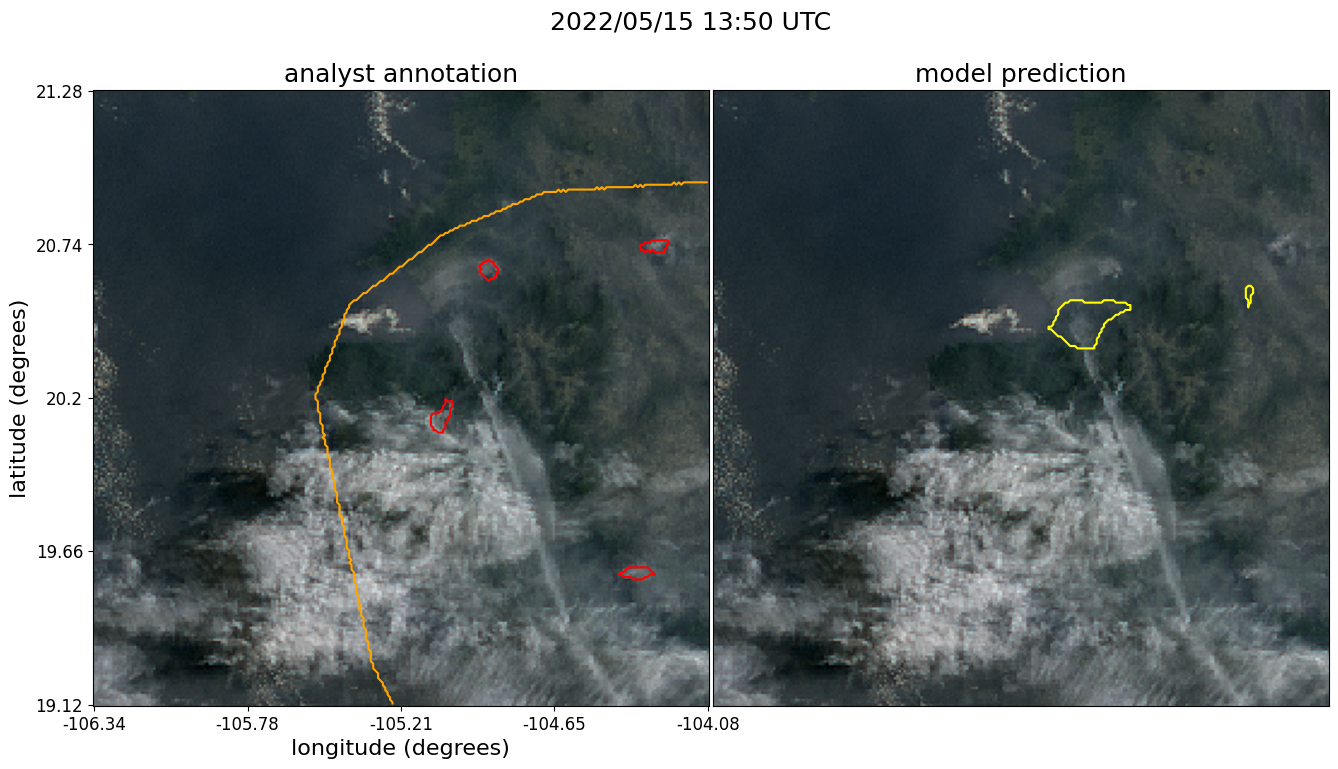

Heavy density smoke gives: 0.0 IoU
Medium density smoke gives: 0.0 IoU
Low density smoke gives: 0.0071258544921875 IoU


In [45]:
from result_plots import plot_test_results  # Import custom plotting function for visualizing results

# Iterate over the test_loader to evaluate the model on a batch of data
for data in test_loader:
    # Unpack the batch into data (input images), labels (ground truth masks), and filenames
    batch_data, batch_labels, fn = data
    print(fn[0])  # Print the current filename being processed
    
    # Move the data and labels to the chosen device (CPU or GPU) and cast them to float
    batch_data, batch_labels = batch_data.to(device, dtype=torch.float), batch_labels.to(device, dtype=torch.float)
    
    # Forward pass through the model to obtain predictions
    pred = model(batch_data)
    
    # Apply the sigmoid activation to map predictions to the range [0, 1]
    pred = torch.sigmoid(pred)
    
    # Threshold predictions at 0.5 to create binary masks
    # Values > 0.5 become 1 (smoke), values <= 0.5 become 0 (no smoke)
    pred = (pred > 0.5) * 1
    
    # Plot the input data, ground truth, and predictions
    plot_test_results(batch_data.squeeze(0), batch_labels.squeeze(0), pred.squeeze(0), fn[0], save_fig=False)
    
    # Compute and print Intersection over Union (IoU) for the predictions
    compute_iou(pred, batch_labels)
    
    # Break after processing the first sample for visualization purposes
    # Remove this break if you want to iterate over the entire dataset
    break


## 2.7. Train your own model

### 2.7.1. Define Model
We redefine the model without the loaded checkpoint weights

In [55]:
# Can redefine the segmentation_model and encoder if desired
model = define_model(segmentation_model, encoder, device)

### 2.7.1 Loss Function

#### 2.7.1.1 Binary Cross Entropy

To train the model, we need a way to quantify the difference between predicted and true values. Here, we use binary cross entropy (BCE) applied independently to each smoke density category.

Each pixel is treated as a separate binary classification task, using [thermometer encoding](#thermometer_encoding) to represent smoke intensity levels.


In [56]:
def train_model(train_dataloader, val_dataloader, model, n_epochs, optimizer, start_epoch=0, best_loss=10000.0):
    """
    Train a segmentation model with BCEWithLogits loss for multiple smoke density classes.

    Args:
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        model (torch.nn.Module): Model to train.
        n_epochs (int): Number of training epochs.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        start_epoch (int, optional): Starting epoch (useful for resuming training).
        best_loss (float, optional): Initial best validation loss (used for checkpointing).

    Returns:
        model (torch.nn.Module): The trained model.
        history (dict): Dictionary containing training and validation losses per epoch.
    """

    # Dictionary to store training and validation losses
    history = dict(train=[], val=[])

    # Binary Cross Entropy with Logits loss (applied separately to each class)
    BCE_loss = nn.BCEWithLogitsLoss()

    # Loop over epochs
    for epoch in range(start_epoch, n_epochs):
        total_loss = 0.0
        print('--------------\nStarting Epoch: {}'.format(epoch), flush=True)

        # Set the model to training mode
        model.train()
        torch.set_grad_enabled(True)

        # Loop over training batches
        for batch_idx, data in enumerate(train_dataloader):
            print('batch number: ', batch_idx)

            # Extract input data and labels, and move them to the device
            batch_data, batch_labels, _ = data
            batch_data = batch_data.to(device, dtype=torch.float)
            batch_labels = batch_labels.to(device, dtype=torch.float)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            preds = model(batch_data)

            # Compute loss for each smoke density class (heavy, medium, low)
            heavy_loss = BCE_loss(preds[:, 0, :, :], batch_labels[:, 0, :, :]).to(device)
            med_loss   = BCE_loss(preds[:, 1, :, :], batch_labels[:, 1, :, :]).to(device)
            low_loss   = BCE_loss(preds[:, 2, :, :], batch_labels[:, 2, :, :]).to(device)

            # Weighted total loss (heavier penalty for misclassifying heavy/medium smoke)
            loss = 3 * heavy_loss + 2 * med_loss + low_loss

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Track the batch loss
            train_loss = loss.item()
            total_loss += train_loss

        # Average loss for the epoch
        epoch_loss = total_loss / len(train_dataloader)
        print("Training Loss:   {0}".format(round(epoch_loss, 8), epoch+1), flush=True)

        # Evaluate on the validation set
        val_loss = val_model(val_dataloader, model, BCE_loss)
        history['val'].append(val_loss)
        history['train'].append(epoch_loss)

        # Save checkpoint if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss
            }
            torch.save(checkpoint, './models/checkpoint.pth')

    print(history)
    return model, history


#### 2.7.1.2 Calculate Validation Loss

The validation set is held out during training and used to monitor model performance after each epoch.

We compute the loss on this set to track generalization. If the validation loss improves (i.e., decreases), the model is saved as a candidate for final deployment.

**Important:** The validation set is only used to evaluate model performance. It is never used to train or update the model.

In [57]:
def val_model(dataloader, model, BCE_loss):
    """
    Evaluate the model on a validation or test dataset using BCEWithLogitsLoss.

    Args:
        dataloader (DataLoader): DataLoader containing validation/test data.
        model (torch.nn.Module): Model to evaluate.
        BCE_loss (torch.nn.BCEWithLogitsLoss): Loss function.

    Returns:
        float: Average validation loss for the dataset.
    """

    # Set the model to evaluation mode (disables dropout, batch norm updates)
    model.eval()
    # Disable gradient computation (reduces memory usage and speeds up inference)
    torch.set_grad_enabled(False)

    total_loss = 0.0  # Accumulate total loss over the dataset

    # Loop over all batches in the validation DataLoader
    for data in dataloader:
        # Unpack the batch and move data/labels to the device
        batch_data, batch_labels, _ = data
        batch_data = batch_data.to(device, dtype=torch.float)
        batch_labels = batch_labels.to(device, dtype=torch.float)

        # Perform a forward pass
        preds = model(batch_data)

        # Compute BCE loss for each smoke density channel (heavy, medium, light)
        heavy_loss = BCE_loss(preds[:, 0, :, :], batch_labels[:, 0, :, :]).to(device)
        med_loss   = BCE_loss(preds[:, 1, :, :], batch_labels[:, 1, :, :]).to(device)
        low_loss   = BCE_loss(preds[:, 2, :, :], batch_labels[:, 2, :, :]).to(device)

        # Weighted total loss (emphasizes heavy and medium smoke misclassifications)
        loss = 3 * heavy_loss + 2 * med_loss + low_loss

        # Convert tensor loss to a scalar value and accumulate
        test_loss = loss.item()
        total_loss += test_loss

    # Compute average loss across all validation batches
    final_loss = total_loss / len(dataloader)
    print("Validation Loss: {}".format(round(final_loss, 8)), flush=True)

    return final_loss


### 2.7.2 Define Hyperparameters

#### 2.7.2.1 Batch Size

The batch size determines how many samples are processed at once during training. Smaller batches use less memory and can introduce more noise in the gradient, which may help escape local minima. If memory allows, a batch size of 32 is a good starting point.

In [58]:
batch_size = 4 # number of samples in a single forward/backward pass 

#### 2.7.2.2 Learning Rate

The learning rate controls how large a step the optimizer takes when updating model weights. It plays a key role in how quickly and effectively the model converges toward a minimum of the loss function.

In [59]:
lr = 5e-3 # learning rate

#### 2.7.2.3 Optimizer

We use the [Adam optimizer](https://arxiv.org/abs/1412.6980), a variant of stochastic gradient descent that adapts the learning rate for each parameter using estimates of first and second moments of the gradients.

In [60]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=lr)

### 2.7.2. Build training and validation dataloaders

In [61]:
# Create the training and validation datasets using the custom SmokeDataset class
train_set = SmokeDataset(data_dict['train'], data_transforms)  # Training dataset
val_set = SmokeDataset(data_dict['val'], data_transforms)      # Validation dataset

# Print the number of samples in each dataset split
print('There are: \n{} training samples \n{} validation samples \n{} testing samples'.format(
    len(train_set), len(val_set), len(test_set))
)

# Create DataLoaders for batching and shuffling the data
# - batch_size: number of samples per batch (defined earlier)
# - shuffle=True for training to improve model generalization
# - drop_last=True ensures that all batches have the same size
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

There are: 
16 training samples 
10 validation samples 
10 testing samples


### 2.7.4. Start training

In [62]:
n_epochs = 5 # number of epochs to run the model
model, history = train_model(train_loader, val_loader, model, n_epochs, optimizer)

--------------
Starting Epoch: 0
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   1.77806301
Validation Loss: 2.73977566
--------------
Starting Epoch: 1
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   2.15991047
Validation Loss: 6.5866667
--------------
Starting Epoch: 2
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   2.8750499
Validation Loss: 6.59340858
--------------
Starting Epoch: 3
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   1.90867247
Validation Loss: 8.07418823
--------------
Starting Epoch: 4
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   1.34474219
Validation Loss: 7.46953285
{'train': [1.7780630104243755, 2.1599104702472687, 2.875049903988838, 1.9086724743247032, 1.3447421863675117], 'val': [2.7397756576538086, 6.586666703224182, 6.593408584594727, 8.074188232421875, 7.46953284740448]}


### Plot Loss

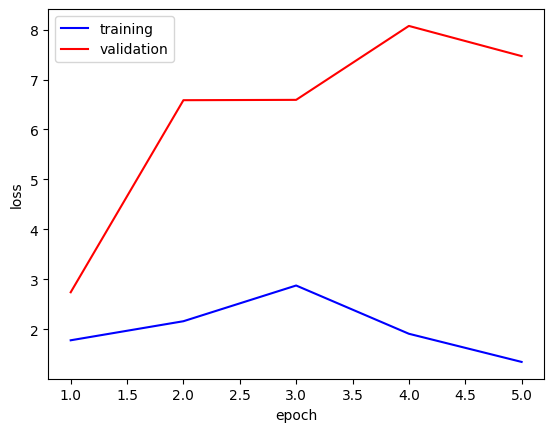

In [63]:
def plot_loss(history):
    train_loss = history['train']
    val_loss = history['val']
    plt.plot(np.linspace(1,len(train_loss), len(train_loss)), train_loss, 'b', label='training')
    plt.plot(np.linspace(1,len(val_loss), len(val_loss)), val_loss, 'r', label='validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
plot_loss(history)

## 2.8. Continue training from checkpoint
This section shows how to resume training a model from a saved checkpoint. By restoring the model weights, optimizer state, and training epoch, you can continue improving performance without starting from scratch.

In [66]:
# Load model weights and training metadata (epoch, loss, optimizer state) from a saved checkpoint
model, chkpt = load_checkpoint(model, checkpoint_path, device)

# Restore the optimizer state (momentum, learning rate, etc.) from the checkpoint
optimizer.load_state_dict(chkpt['optimizer_state_dict'])

# Resume training from the saved epoch
start_epoch = chkpt['epoch']

# Keep track of the best validation loss seen so far
best_loss = chkpt['loss']

# Print the current epoch and best validation loss
print('Current epoch: {} \nBest validation loss: {}'.format(start_epoch, best_loss))

# Continue training the model using the train and validation DataLoaders
model, history = train_model(train_loader, val_loader, model, n_epochs, optimizer)

current epoch: 14 
best validation loss: 1.0147405250204935
--------------
Starting Epoch: 0
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   0.62827362
Validation Loss: 1.1944775
--------------
Starting Epoch: 1
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   0.46488925
Validation Loss: 1.54020727
--------------
Starting Epoch: 2
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   0.33175413
Validation Loss: 1.80454314
--------------
Starting Epoch: 3
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   0.28425665
Validation Loss: 2.15664375
--------------
Starting Epoch: 4
batch number:  0
batch number:  1
batch number:  2
batch number:  3
Training Loss:   0.24043087
Validation Loss: 2.46206641
{'train': [0.6282736212015152, 0.4648892506957054, 0.331754133105278, 0.2842566482722759, 0.24043086543679237], 'val': [1.1944774985313416, 1.54020726680755

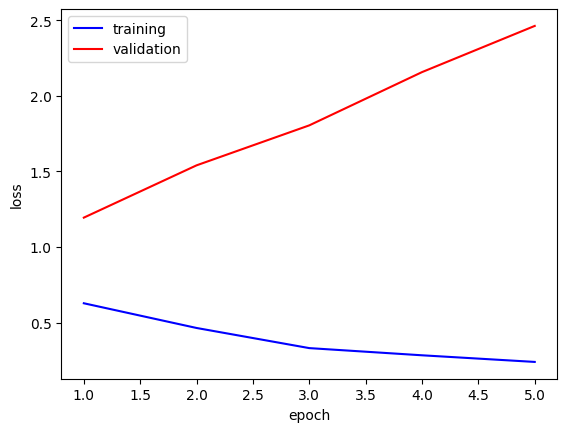

In [67]:
plot_loss(history)

When resuming from a previously trained model, we expect the initial loss to be lower compared to training from scratch, since the model has already learned useful patterns from the data.


## Exercises

Try the following to reinforce your understanding:

#### 1. Try a Different Model
Swap out PSPNet for another model in the [`segmentation_models`](https://smp.readthedocs.io/en/latest/models.html) library, like Unet or DeepLabV3. Train the model and see how the results compare.

#### 2. Change the Learning Rate
In the training section, try using a smaller or larger learning rate. Watch how it affects training speed and accuracy.

#### 3. Look at Model Mistakes
After making predictions, look at where the model got it wrong. Can you spot patterns in the errors? Try visualizing where the model missed smoke or predicted it incorrectly.

## Next Steps
Now that you’ve trained and evaluated a smoke segmentation model on GOES satellite imagery, consider the following next steps:

#### Fine-tune the model  
Continue training the model on a larger dataset or with different hyperparameters to improve performance.

#### Experiment with new architectures  
We demonstrate using the `timm-efficientnet-b0` encoder, try other segmentation encoders within the `segmentation models` library.

#### Apply the model to other regions or dates  
  Use the model to detect smoke in different geographic areas or during active fire seasons not included in training.

#### Perform a per-month inference run
Investigate seasonal smoke trends.

#### Incorporate additional inputs
Add other satellite channels or meteorological variables to improve model accuracy.


## Data Statement

- HMS annotations are produced by NOAA analysts and made available at [OSPO](https://www.ospo.noaa.gov/Products/land/hms.html).
- GOES ABI Level 1b data is publicly hosted by NOAA on [AWS Open Data](https://registry.opendata.aws/noaa-goes/).

## References

SatPy Developers, 2024: SatPy Documentation. https://satpy.readthedocs.io.

GOES-R Program Office, 2024: GOES-R Series Overview. NOAA, https://www.goes-r.gov.

Bah, M. K., M. M. Gunshor, and T. J. Schmit, 2018: Generation of GOES‑16 True Color Imagery without a Green Band. Earth and Space Science, 5, 549–558, doi:10.1029/2018EA000379.

Zhao, H., J. Shi, X. Qi, X. Wang, and J. Jia, 2017: Pyramid Scene Parsing Network. Proc. IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), Honolulu, HI, IEEE, 2881–2890, https://doi.org/10.1109/CVPR.2017.660.

Kingma, D. P., and J. Ba, 2015: Adam: A method for stochastic optimization. Proc. 3rd Int. Conf. on Learning Representations (ICLR), San Diego, CA, arXiv:1412.6980. https://arxiv.org/abs/1412.6980


## Disclaimer and License

This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.